# Python functions - Overview

**Coding party OpenTURNS, March 2023**

_Michaël Baudin_

The goal of this session is to get an overview of Python functions. We present the type of function, its purpose and the type of code that the user must provide.

In [1]:
import openturns as ot
import openturns.viewer as otv
import numpy as np

ot.__version__

'1.19'

## A generic framework

![ABC Methodology](../images/MethodologieIncertitude-EN_arial.png)

**Figure 1.** Defining the physical model $g$ is the begining of any uncertainty study.

## Definition of a Function in OpenTURNS

In OpenTURNS, a `Function` is defined from ([see](https://github.com/openturns/openturns/blob/18146c0a82819c3f8d8e691a119a93c155429422/lib/src/Base/Func/openturns/Function.hxx#L74):
- an evaluation which has an input `Point` and returns an output `Point` (see [Evaluation](https://github.com/openturns/openturns/blob/18146c0a82819c3f8d8e691a119a93c155429422/lib/src/Base/Func/openturns/Evaluation.hxx#L83)) ;
- the gradient which has an input `Point` and returns an output `Matrix` (see [GradientImplementation](https://github.com/openturns/openturns/blob/18146c0a82819c3f8d8e691a119a93c155429422/lib/src/Base/Func/openturns/GradientImplementation.hxx#L82)) ;
- the hessian which has an input `Point` and returns and output `SymmetricTensor` (see [HessianImplementation](https://github.com/openturns/openturns/blob/18146c0a82819c3f8d8e691a119a93c155429422/lib/src/Base/Func/openturns/HessianImplementation.hxx#L79)).


## Different types of Python functions

| Type | Purpose | Implementation |
|---|---|---|
| `PythonFunction` | Point to Point | `function` |
| `OpenTURNSPythonFunction`| Point to Point | `class` |
| `PythonFieldFunction` | Field to Field  |  `function` |
| `PythonPointToFieldFunction` | Point to Field  |  `function` |
| `PythonFieldToPointFunction` | Field to Point |  `function` |
| `OpenTURNSPythonFieldFunction` | Field to Field |  `class` |
| `OpenTURNSPythonPointToFieldFunction` | Point to Field | `class` |
| `OpenTURNSPythonFieldToPointFunction` | Field to Field | `class` |

**Table 1.** Different types of Python functions depending on the inputs and outputs and the code the user must provide.

Below is a collection of relevant and interesting help pages.

| Link | Type |
|---|---|
| [Defining Python and symbolic functions](https://openturns.github.io/openturns/latest/auto_functional_modeling/vectorial_functions/plot_quick_start_functions.html#sphx-glr-auto-functional-modeling-vectorial-functions-plot-quick-start-functions-py) | `PythonFunction` |
| [Define a function with a field output](https://openturns.github.io/openturns/latest/auto_functional_modeling/field_functions/plot_viscous_fall_field_function.html#sphx-glr-auto-functional-modeling-field-functions-plot-viscous-fall-field-function-py) | `PythonPointToFieldFunction` |
| [Wrapper development](https://openturns.github.io/openturns/latest/developer_guide/wrapper_development.html) | `coupling_tools` |

**Table 2.** Help pages which present the use of Python functions.



## Why may we use a Python function?

There are several reasons to use a Python function.

- Use **existing Python code** implementing a physical model $g$. This model may use `numpy`, `scipy` or a dedicated API (e.g. `AsterStudy` or `Telemac`).
- Achieve a **great flexibility** in the code, involving several other Python functions or classes.
- Provide the code to **another user**, with the possibility to **maintain the code** easily.
- Get **performance** by parallelizing the evaluation.

## What is the PythonFunction necessary and useful?

Surprise for a Python user:

- Providing a `PythonFunction` class in a Python library may seem surprising. 
- Other libraries (e.g. `scipy`) do not require that.

Discussion:

- The `PythonFunction` is **necessary**, because OpenTURNS is a C++ library accessible through SWIG.
- It is **useful**, because OpenTURNS provides many different types of functions so that each algorithm can be as efficient as possible.

Examples:

- The `ParametricFunction` class is useful for calibration algorithms.
- The `DistanceToDomainFunction` class is useful for HSIC indices.
- The `Point(or Field)toPoint(or Field)Function` is class is useful for stochastic processes.

## The simplest possible example

In [2]:
def mySimulator(x):
    y0 = x[0] + x[1] + x[2]
    y1 = x[0] - x[1] * x[2]
    y = [y0, y1]  # Will be converted to a Point by SWIG
    return y


gFunction = ot.PythonFunction(3, 2, mySimulator)
x = [1.0] * 3  # Will be converted to a Point by SWIG
print("x = ", x)
y = gFunction(x)
print("y = ", y)

x =  [1.0, 1.0, 1.0]
y =  [3,0]


## Other ways to implement a function

We may also consider other ways to implement a function.

| Class | Advantages | Drawbacks |
|---|---|---|
| `PythonFunction` | Flexible | Not always the fastest |
| `SymbolicFunction` | Exact gradient (not always), fast (not always) | Limited features |

**Table 3.** Comparison of Python and symbolic functions.



| Tool | Features | Pros/Cons | Link |
|---|---|---|---|
| Otwrapy | Multithread, distributed evaluation | Can be fast, depending on the situation | [doc](https://openturns.github.io/otwrapy/master/)|
| Autograd | Automatic differentiation | Not always possible | [doc](https://github.com/HIPS/autograd) |
| Jax | Automatic differentiation | Not always possible | [doc](https://github.com/google/jax) |
| `coupling_tools` | Connect to an external program using files | Slow (depends on the speed of the disk) | [doc](https://openturns.github.io/openturns/latest/developer_guide/wrapper_development.html) |

**Table 4.** Tools to consider when using a Python function.

More details :
- See `Coupling Tools.ipynb` in this repository for details on `coupling_tools`.
- More details on `Otwrapy` and `Jax` latex in the slides.

## Benchmark

We consider the function $g : \mathbb{R}^3 \rightarrow \mathbb{R}^2$:
$$
\begin{aligned}
    y_0 &= x_1 + x_2 + x_3 \\
    y_1 &= x_1 - x_2 x_3
\end{aligned}
$$
for any $\boldsymbol{x}\in \mathbb{R}^3$. 

- The input distribution has $\mathcal{N}(0,1)$ independent marginals : generating the input sample is fast. 
- We call the `getSample()` method of the output random vector. 
- The evaluation is relatively fast.
- The vectorization is achieved using the `func_sample` keyword and the `numpy` library. 

![Python benchmark](../images/wrapper-python-benchmark.png)

**Figure 2.** A benchmark of two Python functions vs a symbolic function (see `python_benchmark.py`).

We see that, on this example, the two fastest methods are the symbol function and the vectorised Python functions. 

Comments :

- See also the benchmark available [in the doc](https://openturns.github.io/openturns/latest/developer_guide/wrapper_development.html#performance-considerations).

- The performance of the symbolic function may depend on the backend `ExprTk` or `MuParser`. This can be configured using the `SymbolicParser-Backend` key of the `ResourceMap`.

In [3]:
ot.ResourceMap.Set("SymbolicParser-Backend", "ExprTk")  # The default
ot.ResourceMap.Set("SymbolicParser-Backend", "MuParser")

## How can PythonFunction be made fast?

The `PythonFunction` is based on the `OpenTURNSPythonFunction` than we will present later in the slides.

Depending on the `func_sample` and `n_cpus` options, we can make the evaluation faster. 
- `func_sample`: evaluate the function on a `Sample` instead of a `Point` to vectorize the evaluations ;
- `n_cpus`: uses `multiprocessing` to make the evaluations parallel.

Here are different cases, depending the options specified by the user:
- If `func_sample` is undefined and `n_cpus` is undefined (i.e. the default), then the user-provided `func` function is used. It is not made parallel by OpenTURNS (but the user can do so).  
- If `func_sample` is undefined and `n_cpus` is defined, then the implementation uses `multiprocessing`'s `Pool` to make the evaluation parallel (see [`_exec_sample_multiprocessing_func`](https://github.com/openturns/openturns/blob/18146c0a82819c3f8d8e691a119a93c155429422/python/src/Function.i#L213))
- If `func_sample` and `n_cpus` are both defined, then the implementation uses divides the `Sample` into sub-samples which are evaluated in parallel (see [`_exec_sample_multiprocessing_func_sample`](https://github.com/openturns/openturns/blob/18146c0a82819c3f8d8e691a119a93c155429422/python/src/Function.i#L282)). 

## What is the memoryview class?

The `memoryview` object is the type of object we receive as input to a `PythonFunction`.

This class provides a lightweight object which prevent unnecessary object copies which can make the evaluation slower. 

In [4]:
def mySimulator(x):
    print("Type of x : ", type(x))
    # dimension = x.getDimension()  # Fail
    y0 = x[0] + x[1] + x[2]
    y1 = x[0] - x[1] * x[2]
    y = [y0, y1]
    return y


gFunction = ot.PythonFunction(3, 2, mySimulator)
x = [1.0] * 3
print("x = ", x)
y = gFunction(x)
print("y = ", y)

x =  [1.0, 1.0, 1.0]
Type of x :  <class 'openturns.memoryview.Buffer'>
y =  [3,0]


The method `x.getDimension()` fails:
```
AttributeError: 'openturns.memoryview.Buffer' object has no attribute 'getDimension'
```

From the [doc](https://openturns.github.io/openturns/latest/user_manual/_generated/openturns.PythonFunction.html#):

*"For efficiency reasons, these functions do not receive a `Point` or `Sample` as arguments, but a proxy object which gives access to internal object data. This object supports indexing, but nothing more. It must be wrapped into another object, for instance `Point` in `func` and `Sample` in `func_sample`, or in a Numpy `array`, for vectorized operations."*

If we have to , we can convert the `memoryview` into a `Point`: this can make the evaluation slower, but can be necessary in some situations.

In [5]:
def mySimulator(x):
    x = ot.Point(x)  # Convert to Point, but only if necessary
    print("Type of x : ", type(x))
    dimension = x.getDimension()  # Ok
    y0 = 0.0
    for i in range(dimension):
        y0 += x[i]
    y1 = x[0] - x[1] * x[2]
    y = [y0, y1]
    return y


gFunction = ot.PythonFunction(3, 2, mySimulator)
x = [1.0] * 3
gFunction(x)

Type of x :  <class 'openturns.typ.Point'>


class=Point name=Unnamed dimension=2 values=[3,0]

## What is the ParametricFunction for?

There are some cases when we want to create a function which has parameters. The `ParametricFunction` can be considered when the parameters is a vector of points:

- to perform [Calibration using least squares](https://openturns.github.io/openturns/latest/auto_calibration/least_squares_and_gaussian_calibration/plot_calibration_deflection_tube.html#sphx-glr-auto-calibration-least-squares-and-gaussian-calibration-plot-calibration-deflection-tube-py) : the parameter to calibrate is the parameter of the `ParametricFunction` ;
- to perform [Bayesian calibration](https://openturns.github.io/openturns/latest/auto_calibration/bayesian_calibration/plot_bayesian_calibration_flooding.html) : the input of the `ParametricFunction` function is the parameter for which we want the *posterior* distribution ;
- to solve optimization problems with a parametric function (which avoids to create a new function each time the parameters change) ;
- etc.

We consider here the Ishigami test function.

### References

- Ishigami, T., Homma, T. (1990, December). An importance quantification technique in uncertainty analysis for computer models. In Uncertainty Modeling and Analysis, 1990. Proceedings., First International Symposium on (pp. 398-403). IEEE.

In [6]:
def ishigami(x):
    x0, x1, x2, a, b = x
    y0 = np.sin(x0) + a * np.sin(x1) ** 2 + b * x2**4 * np.sin(x0)
    y = [y0]
    return y


gFunctionFull = ot.PythonFunction(5, 1, ishigami)
a = 7.0
b = 0.1
xFull = [0.5, 1.0, 1.5, a, b]
y = gFunctionFull(xFull)
print(y)

[5.67865]


To propage the uncertainty through the Ishigami function, we can set the parameters $a$ and $b$, so that the function only has `(x1, x2, x3)` as input.

Please use the [Ishigami](https://openturns.github.io/openturns/latest/usecases/use_case_ishigami.html) from the library for real simulations.

The next table presents the mapping from the variable name to its index. Notice that Python have indices that start from 0. The `gFunctionFull` function has no parameters. 

| Input variable | Input index |
|---|---|
| $x_1$ | 0 |
| $x_2$ | 1 |
| $x_3$ | 2 |
| $a$ | 3 |
| $b$ | 4 |

| Parameter | Parameter index |
|---|---|
| ∅ | ∅ |

**Table 5.** Input variables and parameters of the (full) `gFunctionFull` function.

In [7]:
indices = [3, 4]
referencePoint = [a, b]
gFunction = ot.ParametricFunction(gFunctionFull, indices, referencePoint)
x = [0.5, 1.0, 1.5]
y = gFunction(x)
print(y)

[5.67865]


Manage parameters:

- We can use the `setParameter()` to set the parameters (and `getParameter()` to get them). 
- The `parameterGradient()` returns the gradient of the function with respect to the parameters. 

In [8]:
print(gFunction.getParameter())
gFunction.setParameter([8.0, 0.2])
print(gFunction.getParameter())

[7,0.1]
[8,0.2]


The next table present the inputs and parameters of the parametric `gFunction` function. It has 3 inputs and 2 parameters.


| Input variable | Input index |
|---|---|
| $x_1$ | 0 |
| $x_2$ | 1 |
| $x_3$ | 2 |


| Parameter | Parameter index |
|---|---|
| $a$ | 0 |
| $b$ | 1 |

**Table 6.** Input variables and parameters of the (parametric) `gFunction` function.


## Why is the OpenTURNSPythonFunction class most powerful?

When the parameters cannot be stored as a single `Point`, we need a more powerful tool: the `OpenTURNSPythonFunction` class provides a way to implement a class so that we can provide any necessary parameter (whatever its type) to the evaluation. 
- The constructor of the object can have any number or type of input arguments, as any `Class` object in Python.
- The calculations which are done in the constructor are done *"once for all"* at the creation of the object, which can make some calculations faster. 

In [9]:
class IshigamiFunction(ot.OpenTURNSPythonFunction):
    def __init__(self, a, b):
        super().__init__(3, 1)
        self.a = a
        self.b = b

    def _exec(self, x):
        y0 = (
            np.sin(x[0])
            + self.a * np.sin(x[1]) ** 2
            + self.b * x[2] ** 4 * np.sin(x[0])
        )
        return [y0]

In [10]:
a = 7.0
b = 0.1
ishigamiFunction = IshigamiFunction(a, b)  # Create the object
gFunction = ot.Function(ishigamiFunction)  # Convert to a Function
x = [0.5, 1.0, 1.5]
y = gFunction(x)
print(y)

[5.67865]


Other examples:
- in the PRACE training [a wrapper to the cantilever beam](https://github.com/mbaudin47/hpcuqtraining/blob/773ddaed56339ddb548f82a2ff16bfcf5c00be2c/2019/Scripts/wrapper.py) ;
- in otbenchmark, the [Dirichlet](https://github.com/mbaudin47/otbenchmark/blob/f33a9c6694cc0bb3e2680164519b82e9f2983977/otbenchmark/DirichletSensitivity.py) test function for sensitivity analysis ;
- in otbenchmark, the [flooding](https://github.com/mbaudin47/otbenchmark/blob/f33a9c6694cc0bb3e2680164519b82e9f2983977/examples/scripts/testCrue-classeOTPFun.py) test case ;
- in otbenchmark, the [Morris](https://github.com/mbaudin47/otbenchmark/blob/f33a9c6694cc0bb3e2680164519b82e9f2983977/otbenchmark/MorrisSensitivity.py) test function.

## Otwrapy

The `otwrapy` package (available at [github](https://github.com/openturns/otwrapy)) provides a `Parallelizer` class that converts any `ot.Function` into a parallel wrapper using either `multiprocessing`, `ipyparallel`, `joblib` or `pathos`.

See the [slides](https://felipeam86.github.io/HPC-Uncertainties-PRACE/)  from Felipe Aguirre Martinez for Otwrapy details.

To install `otwrapy`, use conda ([package](https://anaconda.org/conda-forge/otwrapy)):
```bash
$ conda install -c conda-forge otwrapy
```

The `Parallelizer` class parallelize a `Function`:
```python
import otwrapy as otw
from otwrapy.examples.beam import Wrapper
parallelized_beam_wrapper = otw.Parallelizer(Wrapper())
```

![Python benchmark](../images/benchmark_Morris_otwrapy.png)

**Figure 2.** A benchmark of Morris function from `otmorris` using `otwrapy` (see `benchmark_Morris_otwrapy.py`).

We see that, on this example, the "joblib" backend improves the performance when the number of CPUs is in the range $[4, 6]$. Using more CPUs decreases the performance.

## Jax

[Jax](https://github.com/google/jax) is the new [Autograd](https://github.com/HIPS/autograd). 

- can automatically differentiate native Python and NumPy code.
- uses XLA to compile and run your NumPy programs on GPUs and TPUs.
- can differentiate through loops, branches, recursion, and closures, and it can take derivatives of derivatives of derivatives.
- supports reverse-mode differentiation (a.k.a. backpropagation) via grad as well as forward-mode differentiation, and the two can be composed arbitrarily to any order.

Three main functions:

- `jit()`: speeding up your code,
- `grad()`: taking derivatives,
- `vmap()`: automatic vectorization or batching.

From the [Quickstart](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html) :

```python
import jax.numpy as jnp
from jax import grad, jit, vmap

def sum_logistic(x):
  return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x_small = jnp.arange(3.)
derivative_fn = grad(sum_logistic)
print(derivative_fn(x_small))
```

## Other Python objects

| Class | Purpose | Link |
|---|---|---|
| PythonRandomVector | Simulate a random vector | [Link](https://openturns.github.io/openturns/latest/user_manual/_generated/openturns.PythonRandomVector.html) |
| PythonDistribution | Define a distribution | [Link](https://openturns.github.io/openturns/latest/user_manual/_generated/openturns.PythonDistribution.html)|

**Table 6.** Other Python objects.


## PythonRandomVector

The `PythonRandomVector` class can be used to implement the `getRealization()` method for an object for which the distribution is not necessarily known. 

Other examples:
- implement a [NormalTruncatedToBall](https://github.com/openturns/openturns.github.io/blob/df983978484029a0b9571ca7539483837e8c193f/openturns/1.18/pyplots/PythonRandomVector.py)
- simulate a [Markov chain](https://github.com/mbaudin47/otmarkov/blob/efe3c4e9eda2e10d6103ccc028d7518c0d82468d/otmarkov/MarkovChainRandomVector.py)
- implement a [BoxConstrainedNormal](https://openturns.github.io/openturns/latest/auto_calibration/bayesian_calibration/plot_gibbs_simus.html)

We would like to estimate the PDF of the biased sample variance.

In [11]:
class BiasedSampleVariance(ot.PythonRandomVector):
    def __init__(self, distribution, sample_size):
        super().__init__(1)
        self.setDescription(["$\hat{\sigma}^2_{%d}$" % (sample_size)])
        self.sample_size = sample_size
        dimension = distribution.getDimension()
        self.distribution = distribution

    def getRealization(self):
        sample = self.distribution.getSample(self.sample_size)
        sample_variance = sample.computeCenteredMoment(2)[0]
        return [sample_variance]

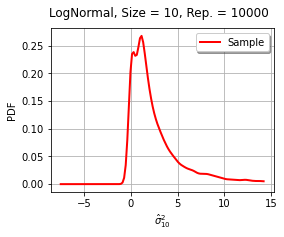

In [12]:
def plot_sample_by_kernel_smoothing(distribution, sample_size, repetitions_size):
    myRV = ot.RandomVector(BiasedSampleVariance(distribution, sample_size))
    sample_variance = myRV.getSample(repetitions_size)

    graph = ot.KernelSmoothing().build(sample_variance).drawPDF()
    graph.setLegends(["Sample"])
    name = distribution.getClassName()
    graph.setTitle("%s, Size = %d, Rep. = %d" % (name, sample_size, repetitions_size))
    return graph


repetitions_size = 10000
view = otv.View(
    plot_sample_by_kernel_smoothing(ot.LogNormal(), 10, repetitions_size),
    figure_kw={"figsize": (4.0, 3.0)},
)

## PythonDistribution

The `PythonDistribution` class defines a distribution. 

The two mandatory methods are:
- `getRange()`;
- `computePDF()`.

Implementing other methods can improve speed and accuracy.

We would like to easily see the asymptotic distribution of the sample variance.

In [13]:
class SampleVarianceAsymptoticDistribution(ot.PythonDistribution):
    def __init__(self, distribution, sample_size):
        super().__init__(1)
        self.distribution = distribution
        self.sample_size = sample_size
        asymptotic_mean = self.distribution.getCenteredMoment(2)[0]
        asymptotic_variance = (
            self.distribution.getCenteredMoment(4)[0] - asymptotic_mean**2
        )
        asymptotic_sd = np.sqrt(asymptotic_variance) / np.sqrt(self.sample_size)
        self.asymptotic_distribution = ot.Normal(asymptotic_mean, asymptotic_sd)

    def computePDF(self, x):
        y = self.asymptotic_distribution.computePDF(x)
        return y

    def computeCDF(self, x):
        y = self.asymptotic_distribution.computeCDF(x)
        return y

    def getRange(self):
        return self.asymptotic_distribution.getRange()

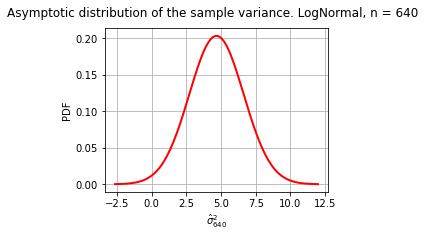

In [14]:
asymptoticDistribution = SampleVarianceAsymptoticDistribution(
    ot.LogNormal(), 640
)  # Create the object
distribution = ot.Distribution(asymptoticDistribution)  # Convert to Distribution
graph = distribution.drawPDF()
graph.setTitle("Asymptotic distribution of the sample variance. LogNormal, n = 640")
graph.setLegends([""])
graph.setXTitle("$\hat{\sigma}_{640}^2$")
view = otv.View(
    graph,
    figure_kw={"figsize": (4.0, 3.0)},
)

## What's next?

Please consider the exercises in this repository:

- `Python_function_exercises.ipynb` : exercises on `PythonFunction` ;
- `Coupling_tools.ipynb`: on `coupling_tools` sub-module to connect to an external program using files ;
- `Parametric_function.ipynb`: exercises on `ParametricFunction` and `OpenTURNSPythonFunction` ;
- `Symbolic_function.ipynb`: exercises on `SymbolicFunction`.
- `python_benchmark.py`: a benchmark with Python functions.